# Fresh take

## 1. Initalize sites

In [ ]:
import os
import os
import shutil
import dbPipeline
import importlib
import time
importlib.reload(dbPipeline)

projectPath = os.path.join(os.getcwd(),'test2')

try:
    shutil.rmtree(projectPath)
except:
    pass

db = dbPipeline.database(projectPath=projectPath)
db.projectInventory()
Sites = r'example_data\projectInventory_Template.yml'
db.projectInventory(newSites=Sites)


In [2]:
import helperFunctions as helper
importlib.reload(dbPipeline)

db = dbPipeline.database(projectPath=projectPath,verbose=False,enableParallel=False)
template = helper.loadDict(r'example_data\source_Template.yml')
# sourcePath = r'U:\EC_Backup\SCL_2024\20240724'
sourcePath = r'example_data'
for siteID in template:
    for measurementID in template[siteID]:
        db.rawFileSearch(siteID,measurementID,sourcePath=sourcePath,**template[siteID][measurementID])

DatetimeIndex(['2024-09-08 05:30:00.050000', '2024-09-08 05:30:00.100000',
               '2024-09-08 05:30:00.150000', '2024-09-08 05:30:00.200000',
               '2024-09-08 05:30:00.250000', '2024-09-08 05:30:00.300000',
               '2024-09-08 05:30:00.350000', '2024-09-08 05:30:00.400000',
               '2024-09-08 05:30:00.450000', '2024-09-08 05:30:00.500000',
               ...
               '2024-09-08 05:59:59.550000', '2024-09-08 05:59:59.600000',
               '2024-09-08 05:59:59.650000', '2024-09-08 05:59:59.700000',
               '2024-09-08 05:59:59.750000', '2024-09-08 05:59:59.800000',
               '2024-09-08 05:59:59.850000', '2024-09-08 05:59:59.900000',
               '2024-09-08 05:59:59.950000',        '2024-09-08 06:00:00'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=36000, freq=None)
                      Ux_mean   Uy_mean   Uz_mean   Ts_mean  \
2024-09-08 06:00:00  2.991156  0.746813  0.028509  9.488572   

                     D

c:\Users\jskeeter\gsc-permafrost\EC_dataPipeline\test2\database\SCL\WSM_Profile\2024\POSIX_timestamp
c:\Users\jskeeter\gsc-permafrost\EC_dataPipeline\dbPipeline.py line 208:
?

c:\Users\jskeeter\gsc-permafrost\EC_dataPipeline\dbPipeline.py line 229:
c:\Users\jskeeter\gsc-permafrost\EC_dataPipeline\test2\database\SCL\WSM_Profile\2024\_variableMap.yml



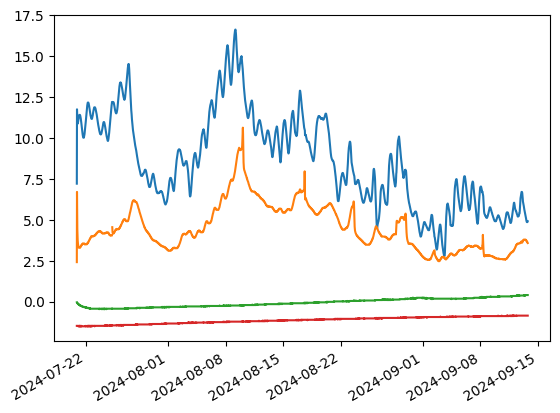

In [168]:
import numpy as np
import matplotlib.pyplot as plt
importlib.reload(dbPipeline)
path = projectPath + r'\database\SCL\Met'
path = projectPath + r'\database\SCL\WSM_Profile'
f = dbPipeline.databaseFolder(path = path,Years= 2024)
fig = plt.figure()
Data = f.dataOut
# Data.loc[((Data['AirTC_Avg']>50)|(Data['AirTC_Avg']<-60)),'AirTC_Avg']=np.nan
# plt.plot(Data['AirTC_Avg'])
plt.plot(Data['TS_1_2_1'])
plt.plot(Data['TS_2_2_1'])
plt.plot(Data['TS_3_2_1'])
plt.plot(Data['TS_4_2_1'])
fig.autofmt_xdate()

In [57]:
import matplotlib.pyplot as plt
import rawDataFile
import importlib
importlib.reload(rawDataFile)
rd = rawDataFile.TOB3(sourceFile=r'u:\EC_Backup\SCL_2024\20240912\Flux_Data495.dat')
# rd.Data['Diagnostic_CSAT']=0
rd.Data.to_csv('SCL_Data_'+rd.fileTimestamp+'.dat',index=False)
# 'Flux_Data_'+rd.fileTimestamp+'.dat'
# rd.fileTimestamp
# rd.Data.to_csv('Test.dat')
# plt.figure()
# plt.plot(rd.Data['Diagnostic_CSAT'][:-1])
rd.Data.shape


c:\Users\jskeeter\gsc-permafrost\EC_dataPipeline\rawDataFile.py line 216:
Frames 3000



(36000, 18)

In [ ]:
import configparser

ini = configparser.ConfigParser()
ini.read(r'config_files/GHG_md_template.metadata')
for s in ini.sections():
    if s != 'Files':
        for key,value in (ini[s].items()):
            ini[s][key] = ''
ini

with open(r'config_files/GHG_ep_template.metadata', 'w') as f:
    f.write(';GHG_METADATA\n')
    ini.write(f,space_around_delimiters=False)